# Local coordinate aperture photometry for input to DSLR data worksheet

## Definitions

### Imports

In [542]:
import os

from collections import OrderedDict

import numpy as np
import pandas as pd

from astropy.io import fits
from astropy.visualization import astropy_mpl_style

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
plt.style.use(astropy_mpl_style)
%matplotlib inline

from PythonPhot import aper

### Functions

#### Photometry of a list of FITS files, creating a table of times and instrumental magnitudes

In [543]:
def multi_file_photometry(fits_root, fits_files, data_index, coords, dataframe, 
                          aperture_radius, inner_sky_radius, outer_sky_radius, 
                          gain=1, zeropoint=0, suffix='.fit'):
    
    for fits_file in fits_files:
        fits_file_path = os.path.join(fits_root, fits_file)
        hdus = fits.open(fits_file_path)
            
        instr_mags = []
        for x, y in coords:
            time, mag = aperture_photometry(hdus[data_index], x, y, 
                                            aperture_radius, inner_sky_radius, outer_sky_radius,
                                            gain=gain, zeropoint=zeropoint)
            instr_mags.append(mag)
        
        dataframe[fits_file[0:fits_file.rindex(suffix)]] = [time] + instr_mags  

#### Single image+coordinate photometry, returning a time and instrumental magnitude. Invoked by multi_file_photometry()

In [544]:
def aperture_photometry(hdu, x, y, 
                        aperture_radius, inner_sky_radius, outer_sky_radius, 
                        gain=1, zeropoint=0):

    image_data = hdu.data
    time = hdu.header[time_name]
        
    mag, magerr, flux, fluxerr, sky, skyerr, badflag, outstr = \
                aper.aper(image_data, x, y, phpadu=gain, 
                          apr=aperture_radius, zeropoint=zeropoint,
                          skyrad=[inner_sky_radius, outer_sky_radius], 
                          exact=True)

    return time, mag[0]

#### Display an image with target and reference stars annotated, to sanity check local coordinates

In [545]:
def show_image(image_data, coord_map, aperture_size, vmin=10, vmax=200, figx=20, figy=10):
    fig = plt.figure(figsize=(figx, figy))
    plt.imshow(image_data, cmap='gray', vmin=vmin, vmax=vmax)
    plt.gca().invert_yaxis()
    plt.colorbar()

    for designation in coord_map:
        xy = coord_map[designation]
        annotate_image(fig.axes[0], designation, xy, aperture_size)
    
    plt.show()

#### Annotate plot axis with coordinate positions and designations. Invoked by show_image()

In [546]:
def annotate_image(axis, designation, xy, aperture_size):
    axis.plot(xy[0], xy[1], 'o', markersize=aperture_size, 
              markeredgecolor='r', markerfacecolor='none', 
              markeredgewidth=2)
    
    offsetbox = TextArea(designation, minimumdescent=False)

    ab = AnnotationBbox(offsetbox, xy,
                        xybox=(-20, 40),
                        xycoords='data',
                        boxcoords="offset points",
                        arrowprops=dict(arrowstyle="->"))
    
    axis.add_artist(ab)        

## Inputs

### File settings

In [547]:
root = "/Users/david/_photometry_working"

# Instrumental magnitude output file path
instr_mag_file_root = root
instr_mag_csv_file = "instr_mags.csv"

# FITS file directory
fits_root = root

# B, G, and R FITS file prefixes to identify files,
# e.g. stk-median-g matches stk-median-g1.fit, stk-median-g2.fit, ... 
b_fits_prefix = "stk-median-b"
g_fits_prefix = "stk-median-g"
r_fits_prefix = "stk-median-r"

# FITS file data HDU index
data_index = 0

# Time column name
time_name = "JD"

### Map of object designations to local coordinates

In [548]:
# Ordered dictionary of object names/IDs to local coordinates
position_map = OrderedDict({
 # ** Your name-tuple pairs go here **
 "Nova Cir 2018":(1894.909,1043.986),
 "61 000-BKS-959 (CHK)":(898.374,1755.471),
 "70 000-BFT-998":(1835.340,2058.114),
 "71":(631.509,1740.032),
 "72":(753.645,759.789),
 "73":(1776.770,2112.425),
 "58":(899.464,1361.093),
 "64 000-BKT-761":(1227.494,1623.136)
 # ** END **
})

### Aperture radii and gain

In [549]:
# Apertures
measurement_aperture = 12
inner_sky_annulus = 15
outer_sky_annulus = 20

# ph/ADU
# Note: PythonPhot's aperture photometry function takes a phadu parameter.
# Assumption: this is photons/ADU or e-/ADU, i.e. gain.
gain=1.67

## Outputs

### Find B, G, R files in the FITS file directory

In [550]:
files = os.listdir(fits_root)

b_fits_files = sorted([file for file in files if b_fits_prefix in file])
g_fits_files = sorted([file for file in files if g_fits_prefix in file])
r_fits_files = sorted([file for file in files if r_fits_prefix in file])

### Aperture location sanity check by visual inspection
#### Arbitrarily choose the first G FITS file

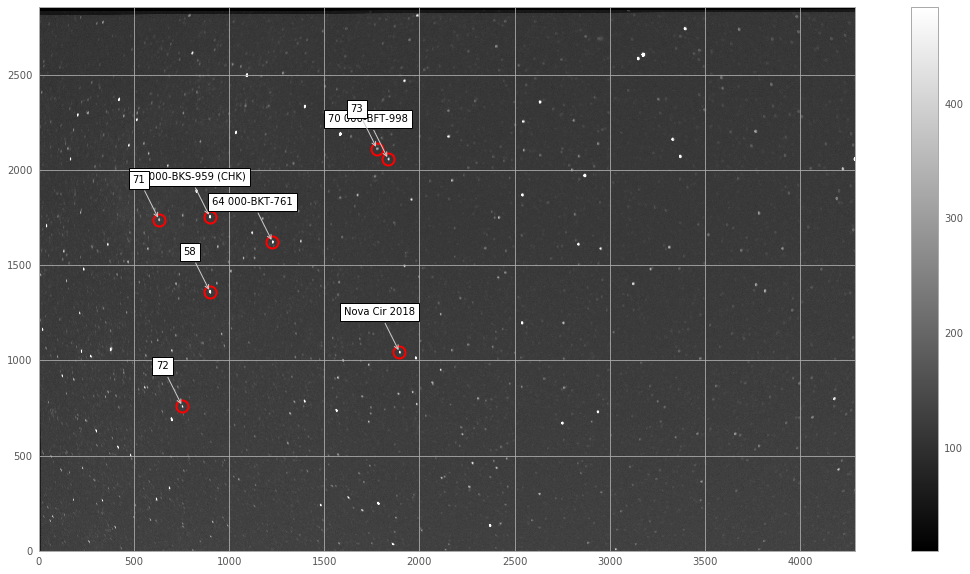

In [551]:
fits_file = g_fits_files[0]

hdus = fits.open(os.path.join(fits_root, fits_file))
image_data = hdus[data_index].data

median = np.median(image_data)
show_image(image_data, position_map, measurement_aperture, vmin=10, vmax=median*4)

### Aperture photometry

In [552]:
# Create empty table with time and object headers
pd.options.display.float_format = '{:,.6f}'.format
instr_mag_df = pd.DataFrame()
names = [name for name in position_map]
instr_mag_df['name'] = [time_name] + names
instr_mag_df.set_index('name', inplace=True)

In [553]:
# Carry out photometry on B, G, R FITS files, yielding instrumental magnitudes
positions = position_map.values()

multi_file_photometry(fits_root, b_fits_files, data_index, positions, instr_mag_df, 
                      measurement_aperture, inner_sky_annulus, outer_sky_annulus, gain=1.67)
multi_file_photometry(fits_root, g_fits_files, data_index, positions, instr_mag_df, 
                      measurement_aperture, inner_sky_annulus, outer_sky_annulus, gain=1.67)
multi_file_photometry(fits_root, r_fits_files, data_index, positions, instr_mag_df, 
                      measurement_aperture, inner_sky_annulus, outer_sky_annulus, gain=1.67)

In [554]:
# Save photometry table as CSV
instr_mag_csv_path = os.path.join(instr_mag_file_root, instr_mag_csv_file)
instr_mag_df.T.to_csv(instr_mag_csv_path)

# Display photometry table
instr_mag_df.T

name,JD,Nova Cir 2018,61 000-BKS-959 (CHK),70 000-BFT-998,71,72,73,58,64 000-BKT-761
stk-median-b1,"2,458,160.071701",-11.513012,-12.157969,-11.298804,-11.172418,-11.067750,-11.096202,-12.316272,-12.019167
stk-median-b2,"2,458,160.073102",-11.529825,-12.155636,-11.290358,-11.178948,-11.061740,-11.040474,-12.268763,-11.968120
stk-median-b3,"2,458,160.074499",-11.507132,-12.151158,-11.337460,-11.171300,-11.054817,-11.092275,-12.305986,-11.964924
stk-median-b4,"2,458,160.075903",-11.522176,-12.156017,-11.307827,-11.204659,-11.054948,-11.143052,-12.285563,-11.964794
stk-median-b5,"2,458,160.077303",-11.504613,-12.156018,-11.309682,-11.203981,-11.043824,-11.093190,-12.290825,-11.976230
stk-median-g1,"2,458,160.071701",-11.798784,-12.313387,-11.403338,-11.341142,-11.247491,-11.188815,-12.607472,-12.084072
stk-median-g2,"2,458,160.073102",-11.791071,-12.303431,-11.400111,-11.341944,-11.241819,-11.167267,-12.602186,-12.081518
stk-median-g3,"2,458,160.074499",-11.811757,-12.300926,-11.383770,-11.315919,-11.226530,-11.172438,-12.588436,-12.058571
stk-median-g4,"2,458,160.075903",-11.800886,-12.304867,-11.382540,-11.338193,-11.230101,-11.187231,-12.588510,-12.073657
stk-median-g5,"2,458,160.077303",-11.806511,-12.303614,-11.393031,-11.317311,-11.227499,-11.167777,-12.598404,-12.079335


## References
* http://docs.astropy.org/en/stable/io/fits
* http://docs.astropy.org/en/stable/generated/examples/io/plot_fits-image.html
* http://www.astropy.org/astropy-tutorials/FITS-images.html
* https://github.com/djones1040/PythonPhot